# Проект для «Викишоп» с использованием BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 


Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка 

In [1]:
!pip install lightgbm
!pip install scikit-optimize

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import transformers
from tqdm import notebook

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from skopt import BayesSearchCV
from skopt.space import Integer, Real

from lightgbm import LGBMClassifier

import os

In [3]:
pth1 = 'toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [4]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [5]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

<AxesSubplot:>

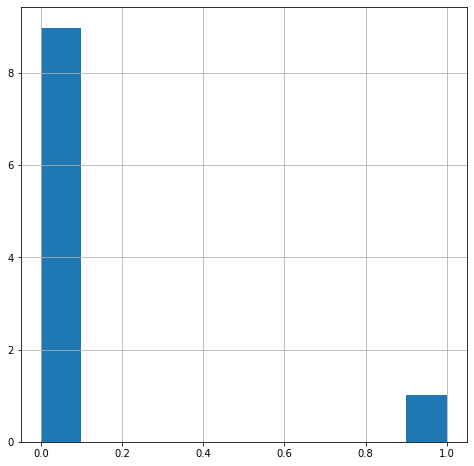

In [6]:
df['toxic'].hist(density=True, figsize=(8,8))

In [7]:
f"Токсичных комментариев в датасете - {df['toxic'].value_counts()[1] / df.shape[0]:.2%}"

'Токсичных комментариев в датасете - 10.17%'

У нас имеется датасет, содержащий комментарии пользователей и отметку, является ли комментарий токсичным или нет. Всего в датасете более 150 тысяч строк. Токсичные комментарии составляют 10% от всех данных.

Т.к. для обучения модели BERT требуется большое количество памяти, будем использовать только часть данных. При этом нужно сохранить исходное соотношение токсичных комментов к нетоксичным.

In [8]:
_, bert_df = train_test_split(df, test_size=.05, stratify=df['toxic'], random_state=42)

In [9]:
bert_df.head()

,text,toxic
116312,"""\n\nI want to know who is the """"Human rights ...",0
17270,Category:WikiProject Energy development articl...,0
79760,"""*It might not have been your intention, but y...",0
3623,"""\nThank you for your kindness. (Talk • Contr...",0
14421,1938 Colombia air accident \n\n:es:Accidente a...,0


In [10]:
bert_df.shape

(7979, 2)

<AxesSubplot:>

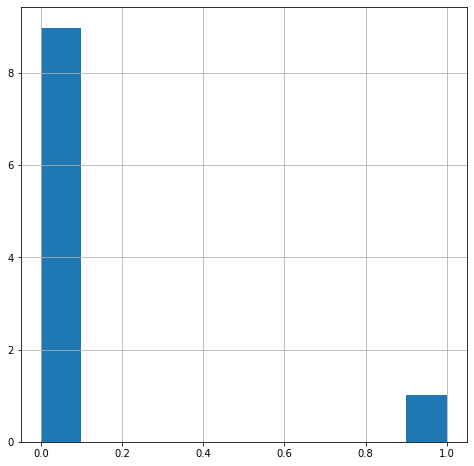

In [11]:
bert_df['toxic'].hist(density=True, figsize=(8,8))

In [12]:
f"Токсичных комментариев в новом датасете - {bert_df['toxic'].value_counts()[1] / bert_df.shape[0]:.2%}"

'Токсичных комментариев в новом датасете - 10.16%'

Соотношение классов сохранено. Можно приступить к обучению.

## Обучение 

### Создание признаков с помощью BERT

Для создания признаков воспользуемся предобученной [моделью для классификации токсичных комментариев](https://huggingface.co/unitary/toxic-bert).

In [13]:
%%time
tokenizer = transformers.AutoTokenizer.from_pretrained("unitary/toxic-bert")
model = transformers.AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert")

tokenized = bert_df['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
padded.shape

CPU times: total: 4.84 s
Wall time: 15 s


(7979, 512)

In [14]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(7979, 512)

In [15]:
batch_size = 79
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0].numpy())

  0%|          | 0/101 [00:00<?, ?it/s]

In [16]:
features = np.concatenate(embeddings)
target = bert_df['toxic']

In [17]:
features.shape

(7979, 6)

In [18]:
target.shape

(7979,)

Признаки сформированы. Выделим из них тестовые и обучающие выборки.

In [19]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = .25, random_state=42, stratify=target)

### Обучение моделей

Обучим разные модели на полученных признаках, а результаты обучения внесем в таблицу.

In [20]:
modeling_results = {
    'name':[],
    'model':[],
    'train_f1':[],
}

#### Логистическая регрессия

In [21]:
%%time

clf = LogisticRegression(random_state=42, class_weight='balanced')
params = {'C':Real(1e-4, 1e+3, prior='log-uniform')}

bs_clf = BayesSearchCV(clf, params, scoring='f1', n_jobs=4, cv=5, verbose=1)
bs_clf.fit(features_train, target_train)

print(f'F1 модели {type(clf).__name__} - {abs(bs_clf.best_score_)}')

modeling_results['model'].append(bs_clf.best_estimator_)
modeling_results['name'].append(type(clf).__name__)
modeling_results['train_f1'].append(abs(bs_clf.best_score_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

D:\Abe\anaconda3\envs\praktikum\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


D:\Abe\anaconda3\envs\praktikum\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


D:\Abe\anaconda3\envs\praktikum\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


D:\Abe\anaconda3\envs\praktikum\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
F1 модели LogisticRegression - 0.9116139968928183
CPU times: total: 24.2 s
Wall time: 28.3 s


#### Случайный лес

In [22]:
%%time

rfc = RandomForestClassifier(random_state=42, class_weight='balanced')
model_params = {
        'n_estimators':Integer(10, 500),
        'max_depth':Integer(1, 16),
        'min_samples_split':Integer(2, 8),
             }

bs_rfr = BayesSearchCV(rfc, model_params, scoring='f1', cv=5, n_jobs=4, n_iter=30, verbose=1)
bs_rfr.fit(features_train, target_train)

print(f'F1 модели {type(rfc).__name__} - {abs(bs_rfr.best_score_)}')

modeling_results['model'].append(bs_rfr.best_estimator_)
modeling_results['name'].append(type(rfc).__name__)
modeling_results['train_f1'].append(abs(bs_rfr.best_score_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

#### LigthGBM

In [23]:
%%time

lgbmclf = LGBMClassifier(random_state=42, class_weight='balanced')
model_params = {
        'learning_rate':Real(1e-2, 1e+6, prior='log-uniform'),
        'n_estimators':Integer(10, 500),
        'max_depth':Integer(1, 11),
             }

bs_lgbm = BayesSearchCV(lgbmclf, model_params, scoring='f1', cv=5, n_jobs=4, n_iter=30, verbose=1)
bs_lgbm.fit(features_train, target_train)

print(f'F1 модели {type(lgbmclf).__name__} - {abs(bs_lgbm.best_score_)}')

modeling_results['model'].append(bs_lgbm.best_estimator_)
modeling_results['name'].append(type(lgbmclf).__name__)
modeling_results['train_f1'].append(abs(bs_lgbm.best_score_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

### Результаты обучения моделей

In [24]:
results = pd.DataFrame(modeling_results, columns=modeling_results.keys())
results

,name,model,train_f1
0,LogisticRegression,"LogisticRegression(C=0.00010033458107843696, c...",0.911614
1,RandomForestClassifier,"(DecisionTreeClassifier(max_depth=7, max_featu...",0.935282
2,LGBMClassifier,"LGBMClassifier(class_weight='balanced', learni...",0.923247


In [25]:
best_train_model = results[results['train_f1']==results['train_f1'].max()].reset_index(drop=True)
print(f'Лучшая модель - {best_train_model.loc[0,"name"]} с показателем F1 равным {best_train_model.loc[0,"train_f1"] :.2f}')

Лучшая модель - RandomForestClassifier с показателем F1 равным 0.94


## Тестирование моделей

Проверим работу моделей на тестовой выборке и дополним таблицу результатми тестирования. На их основе выберем лучшую модель.

In [26]:
for i in range(len(results)):
    model = results.loc[i, 'model']
    model.fit(features_train, target_train)
    predict = model.predict(features_test)
    score = f1_score(target_test, predict)
    results.loc[i, 'test_f1'] = score
    
results

,name,model,train_f1,test_f1
0,LogisticRegression,"LogisticRegression(C=0.00010033458107843696, c...",0.911614,0.897494
1,RandomForestClassifier,"(DecisionTreeClassifier(max_depth=7, max_featu...",0.935282,0.932039
2,LGBMClassifier,"LGBMClassifier(class_weight='balanced', learni...",0.923247,0.917073


In [27]:
best_test_model = results[results['test_f1']==results['test_f1'].max()].reset_index(drop=True)
print(f'Лучшая модель - {best_test_model.loc[0,"name"]} с показателем F1 равным {best_test_model.loc[0,"test_f1"] :.2f}')
print()
if best_test_model.loc[0,"test_f1"] >= 0.75:
    print('Модель прошла проверку')
else:
    print('Тестовая F1-мера меньше 0.75!')

Лучшая модель - RandomForestClassifier с показателем F1 равным 0.93

Модель прошла проверку


## Выводы

В ходе проекта была проведена работа по обучению моделей для предсказания токсичных комментариев с помощью BERT. Исходный датасет содержал 2 колонки: в одной содержались текстовые комментарии, во второй - является ли комментарий токсичным или нет.

1. В ходе подготовки данных было обнаружено, что токсичные комментарии составляют всего 10% от всех данных. Кроме того, т.к. BERT требует большого объема памяти, было принято решение использовать только часть данных с сохранением исходного соотношения классов.

2. Для преобразования текстовых комментариев в векторный вид использовалась предобученная модель BERT [unitary/toxic-bert](https://huggingface.co/unitary/toxic-bert).

3. После получения признаков и выделения обучающей и тествой выборок были обучены 3 разных модели: логистическая регрессия, случайный лес и LightGBM. Результаты моделирования были вынесены в таблицу. После этого все модели были протестированы на тестовой выборке. Все 3 модели имеют значение F1-меры более 0.9. Наилучший результат показала модель RandomForestClassifier с результатом 0.93.